# 1 - Introduction

This notebook will train a baseline linear logistic regression model. The features will be created using the bag of words technique. This means that the input will be known as a document term matrix. The document term matrix will be weighted using term frequency-inverse document (tf-idf) scaling.

The logistic regression will be regularized using the l2 norm. This means that a penalty will be applied to the l2 norm of the coefficients. This will shrink the coefficients towards 0 and each other. The use of the l2 penalty in a regression is also known as ridge regression.

The purpose of this baseline model is twofold. The first is to have benchmark model to which the decision tree and neural network mdoels can bve comapred. The second purpose is to determine the how many features should be in the document term matrix. Given these two purposes, the text lengths will not be inlcuded as a feature. The importance of the text length will be expored using decision trees.

## 1.1 - Load Packages and Global Variables

In [1]:
%matplotlib inline
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import luigi
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from nltk import word_tokenize

In [2]:
PROJECT_DIR = os.path.join(os.getcwd(), os.pardir)
os.chdir(PROJECT_DIR)
from src.data.clean import CleanData
from src.visualization import evaluation

## 1.2 - Prep the Data

The following Luigi task ensures that the cleaned test and train sets are available, and produces them if they are not.

In [3]:
luigi.build([CleanData()], local_scheduler = True)

DEBUG: Checking if CleanData() is complete
INFO: Informed scheduler that task   CleanData__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=636735326, workers=1, host=DESKTOP-6UJS098, username=wertu, pid=6720) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 present dependencies were encountered:
    - 1 CleanData()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

Now that we assured that the data is present, we can load it.

In [4]:
#Load data
train = joblib.load('data/interim/train.pkl')
test = joblib.load('data/interim/test.pkl')

# 2 - Hyperparameter Selection

The optimal regularization penalty will be determined by 10 fold cross validation. In addition to using cross-fold validation to determine the regularization strnegth, this cross validation process will be used to determine the optimal number of columns in the document term matrix, ie the number of features.

## 2.1 - Parameter Path

Before using crossfold validation to determine the optimal regularization strength and number of features, we should intelligently determine a range of values to iterate over.

### 2.1.1 - Features

As mentioned earlier, the features will be structured as a document term matrix. Document term matrices can be quite large.

The point of this exercise is not just to determine 

First, we create a data set containing numerical features that can be used in a regression. The sklearn CountVectorizer class will be used to determine the maximum number of features. Later we will use the TfidfVectorizer to do more stuff. I will use the built in word tokenizer and preprocessing in CountVectorizewr. Keep it simple. Will use 5 grams.

Will require terms to appear in at least five documents. This is kind of arbitrary but will stop spurious terms from appearing.

I will use sklearm's built in stop word list, and in addition will remove terms that appear in 80%+ of documents (kind of like dynamic stop words filteirng).

Stemming and lemmatization will not be explored. This is because recent advances in neural networks and word embeddings are  a much more efficient and elegant way of learning word relations. Neural network with word embeddings will be explored later in this project so that it why we are not putting excessive effort on transforming the words.

In [8]:
%%time
count_vec = CountVectorizer(analyzer = 'word', ngram_range = (1,3), max_df = 0.8, min_df = 5, stop_words = 'english')
count_vec.fit(train.full_text)

Wall time: 1min 11s


What are the maximum amount of terms?

In [9]:
max_features = len(count_vec.vocabulary_)
print(max_features)

231464


Let us explore a feature path of 8 blocks, increasing linearly to the maximum.

In [10]:
feature_path = np.linspace(0,max_features,9,dtype='int')[1:].tolist()
feature_path

[28933, 57866, 86799, 115732, 144665, 173598, 202531, 231464]

### 2.1.2 Regularization

For the C parameters (regularization), we will just use default of sklearn (but put in explicitly). And only do 8 instead of 10. And chop off the ends

In [11]:
cs = np.geomspace(1e-2,1e2, num = 8).tolist()
cs

[0.01,
 0.0372759372031494,
 0.13894954943731375,
 0.517947467923121,
 1.9306977288832496,
 7.196856730011514,
 26.826957952797247,
 100.0]

## 2.2 Crossfold Validation Estimates

We will use accuracy to determine the optimal set of parameters. However that will not be the only criteria. We will lean toward more regulariztion strength and less features. A reduced number of features will help prevent overfitting and reduce the amount of time it takes to train a model. Increased regulurziation strength will reduce help reduce the difference between the crossfold validation score and the test score.

In [12]:
def validate_dtm(max_terms, cpath, folds):
    tfidf = TfidfVectorizer(analyzer='word',
                            ngram_range=(1,3),
                            max_df = 0.8,
                            min_df=5,
                            max_features=max_terms,
                            stop_words = 'english')
    dtm_train = tfidf.fit_transform(train.full_text)
    vocab_len = len(tfidf.vocabulary_)
    print("DTM has {} words".format(vocab_len))
    mdl = LogisticRegressionCV(Cs = cpath, cv = folds, solver = 'lbfgs', max_iter=1250, n_jobs = 1,
                               refit = False, verbose = True, random_state = 10222017)
    mdl.fit(dtm_train, train.funny)
    test_acc = pd.DataFrame(mdl.scores_[True]).mean().values.tolist()
    test_std = pd.DataFrame(mdl.scores_[True]).std().values.tolist()
    return test_acc, test_std

In [13]:
def maxfeatures_cv(feature_path, cpath, folds = 3):
    acc = []
    std = []
    num_features = []
    num_features_indx = []
    cs = []
    cs_indx = []
    for i, max_features in enumerate (feature_path):
        print("Starting DTM {}".format(i))
        max_features = int(max_features)
        
        #get list of C values and associated indexes (lower index is lower C)
        cs.extend(cpath)
        cs_indx.extend(range(0,len(cpath)))
        
        #get list of max_features values and associated indexes, multiplied by number of C values
        num_features.extend(len(cpath) * [max_features])
        num_features_indx.extend(len(cpath) * [i])
        
        cv_acc, cv_std = validate_dtm(max_features, cpath, folds)
        std.extend(cv_std)
        acc.extend(cv_acc)
    results = pd.DataFrame({"num_features":num_features,
                            "num_features_indx":num_features_indx,
                            "accuracy":acc,
                            "StD":std,
                            "C":cs,
                            "C_indx":cs_indx})
    return results

In [14]:
%%time
results = maxfeatures_cv(feature_path, cs, folds = 8)

Starting DTM 0
DTM has 28933 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 23.2min finished


Starting DTM 1
DTM has 57866 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 25.8min finished


Starting DTM 2
DTM has 86799 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.5min finished


Starting DTM 3
DTM has 115732 words


C:\Users\wertu\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 17.9min finished


Starting DTM 4
DTM has 144665 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.9min finished


Starting DTM 5
DTM has 173598 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 19.3min finished


Starting DTM 6
DTM has 202531 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.9min finished


Starting DTM 7
DTM has 231464 words


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 39.6min finished


Wall time: 3h 8min 17s


In [15]:
results = results.sort_values("accuracy", ascending=False)
results["one_std"] = results.accuracy - results["StD"]

In [16]:
results.head(10)

,C,C_indx,StD,accuracy,num_features,num_features_indx,one_std
60,1.930698,4,0.003611,0.680481,231464,7,0.676871
52,1.930698,4,0.003467,0.679518,202531,6,0.676051
44,1.930698,4,0.003350,0.678621,173598,5,0.675271
36,1.930698,4,0.003297,0.677449,144665,4,0.674152
59,0.517947,3,0.003853,0.676200,231464,7,0.672347
28,1.930698,4,0.003554,0.675807,115732,3,0.672253
51,0.517947,3,0.003629,0.675445,202531,6,0.671817
43,0.517947,3,0.003327,0.674655,173598,5,0.671328
35,0.517947,3,0.003306,0.673998,144665,4,0.670692
20,1.930698,4,0.003381,0.673911,86799,2,0.670531


## 3 - Evaluate Results

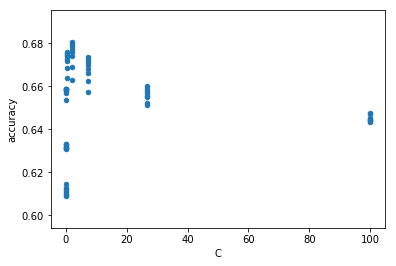

In [17]:
results.plot(x = 'C', y = 'accuracy', kind = 'scatter')

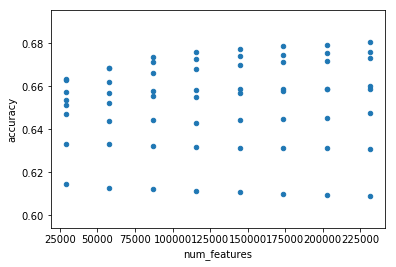

In [18]:
results.plot(x = 'num_features', y = 'accuracy', kind = 'scatter')

## Benchmark on Test

Now that we have used crossfold validation to explore the parameter space, we can train the model on the whole train data using the best set of hyperparameters. We will then evaluate the performance of the model on the test data.

In [19]:
best_C = results.iloc[0].C
max_features = results.iloc[0].num_features

In [33]:
%%time
vectorizer = TfidfVectorizer(analyzer= 'word',
                             ngram_range=(1,3),
                             max_df = 0.8,
                             min_df = 5,
                             max_features = int(max_features),
                             stop_words = 'english')
dtm = vectorizer.fit_transform(train.full_text)
mdl = LogisticRegression(C = best_C, solver = 'lbfgs', max_iter=2000) 
mdl.fit(dtm, train.funny)
test_dtm = vectorizer.transform(test.full_text)

Wall time: 2min 19s


We will first evaluate the accuracy.

In [34]:
test_acc = mdl.score(test_dtm, test.funny)
train_acc = mdl.score(dtm, train.funny)
print("Best linear model has an accuracy of {0:.2%} on the test data.".format(test_acc))
print("Best linear model has an accuracy of {0:.2%} on the train data.".format(train_acc))

Best linear model has an accuracy of 78.46% on the test data.
Best linear model has an accuracy of 80.16% on the train data.


Now that have the accuracy, let's evaluate the the performance of the model using the area under the curve. The area of the curve is our preferred metric. It works better than accuracy when with unbalanced data.

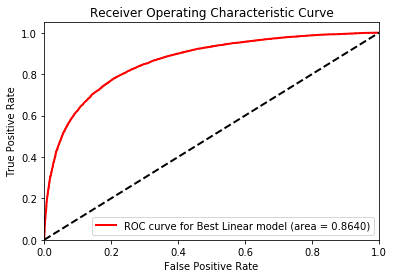

In [29]:
y_predicted = mdl.predict_proba(test_dtm)[:, 1]
evaluation.roc_plot(test.funny,
                    [y_predicted],
                    ["Best Linear"],
                    'reports/figures/ROC_best_linear.svg')

# 3 - Save

In [35]:
dtm_dict = {'train' : dtm,
            'test' : test_dtm,
            'vectorizer' : vectorizer}

joblib.dump(dtm_dict, 'data/processed/dtm_features.pkl')
joblib.dump(mdl, 'models/best_linear.pkl')

['data/processed/dtm_features.pkl']